## Credit Card Fraud Detection ##


### Loading the Dataset ###

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Credit Card Fraud')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings

warnings.filterwarnings('ignore')

The data is stored in a spreadsheet format. As a result, the data can be loaded into a Panda's DataFrame.

In [ ]:
import pandas as pd

df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Below, the information about the data frame can be studied. Note that since credit card data is sensitive and privacy concerns are important, the columns don't contain actual data (with the exception of time and amount). Instead, the columns included are vectors from principal component analysis.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Exploratory Data Analysis ###

Note that as seen in the bar chart below, the two classes are extremely imbalanced. This is reflective of real-world data where there are many more instances of non-fraudulent transactions than fraudulent ones.

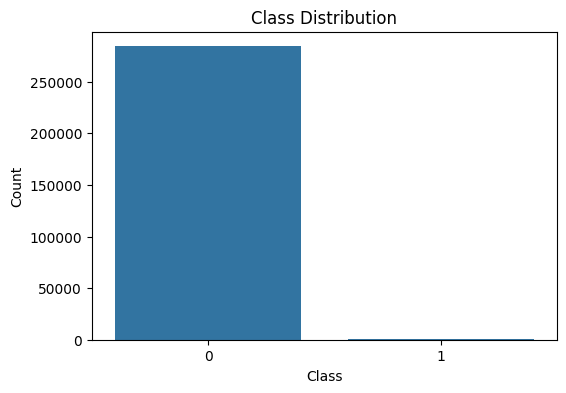

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Similarly, the amounts have a highly skewed distribution. This means amount could potentially be a predictor for fraud if the imbalance follows similar patterns to the fraud label.

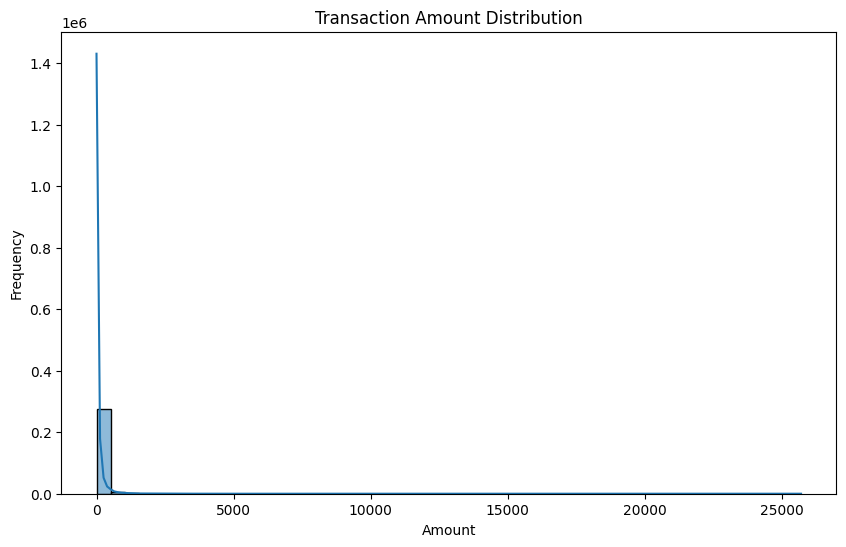

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

When class is broken down by average amounts, we can see that amount isn't significantly different for the two classes, so can't predict with high accuracy.

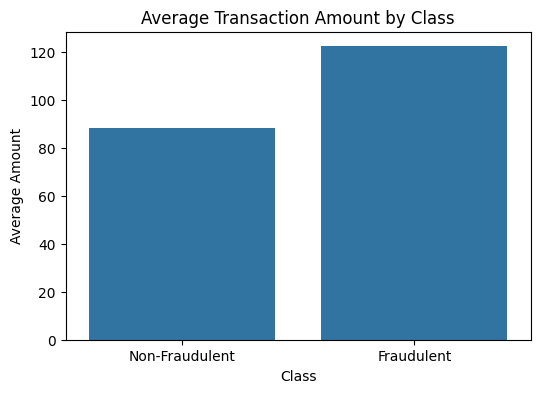

In [ ]:
df_temp = df.groupby('Class')['Amount'].mean()

plt.figure(figsize=(6, 4))
sns.barplot(x=df_temp.index.map({0: 'Non-Fraudulent', 1: 'Fraudulent'}), \
            y=df_temp.values)
plt.title('Average Transaction Amount by Class')
plt.xlabel('Class')
plt.ylabel('Average Amount')
plt.show()

Finally, consider amount over time for the transactions. If time is ignored, trends in the amount over time can mislead the model. However, as seen in the graph below, the average transaction amount doesn't change significantly over time.

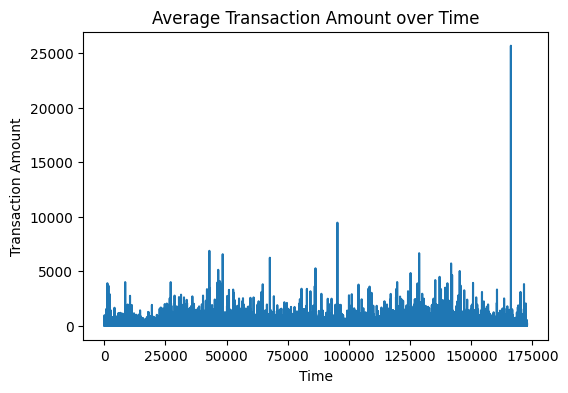

In [ ]:
df_temp = df.groupby('Time')['Amount'].mean()

plt.figure(figsize=(6, 4))
sns.lineplot(x=df_temp.index, y=df_temp.values)
plt.title('Average Transaction Amount over Time')
plt.xlabel('Time')
plt.ylabel('Transaction Amount')
plt.show()

Are there trends across time in the number of fraudulent transactions? As can be seen in the graph below, this is also not the case.

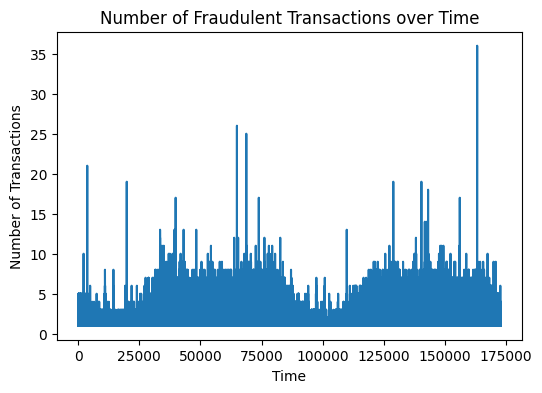

In [ ]:
df_temp = df.groupby('Time')['Class'].count()

plt.figure(figsize=(6, 4))
sns.lineplot(x=df_temp.index, y=df_temp.values)
plt.title('Number of Fraudulent Transactions over Time')
plt.xlabel('Time')
plt.ylabel('Number of Transactions')
plt.show()

Finally, consider correlations between the different variables. Since PCA was used to obtain V1-V27, these variables shouldn't normally be highly correlated. As expected from theory, we can see below that this is in fact the case.

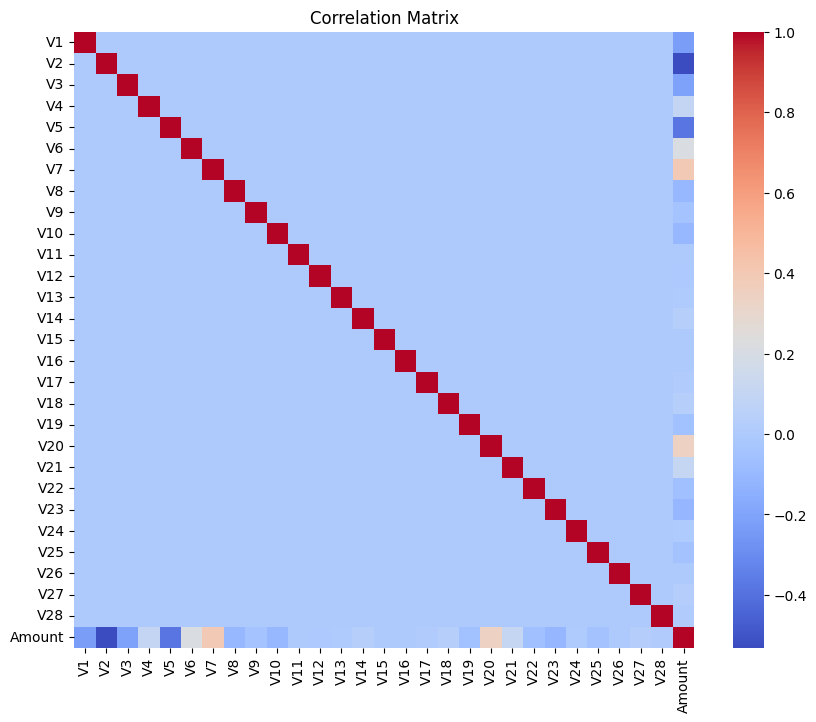

In [ ]:
df_dropped = df.drop(['Time'], axis=1)

corr = df_dropped.drop(['Class'], axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix')
plt.show()

### Model Definition and Training ###

First, we create train, validation, and testing datasets with 60% 20% and 20% of data respectively. To make sure the balance between the two classes isn't altered by the splits, stratified splits are used. This means the same proportion between the two classes is seen across the three folds.

In [ ]:
from sklearn.model_selection import train_test_split

X_dev, X_test, y_dev, y_test = train_test_split(
    df_dropped.drop(['Class'], axis=1), df_dropped['Class'],
    test_size=0.20, random_state=42, stratify=df_dropped['Class'])

X_train, X_val, y_train, y_val = train_test_split(
    X_dev, y_dev, test_size=0.25,
    random_state=42, stratify=y_dev)

While stratified splits avoid some of the pitfalls of working with highly imbalanced data, the trained model can still fail to focus on the minority class. To further mitigate this, both the random forest model and the gradient boosted tree model trained below will use a weight-balanced loss, meaning loss is scaled based on the proportions of the two classes.

Below, a random forest model is trained on the training data. To obtain the best performance out of the model, grid search is implemented. A grid of three hyperparameters: number of trees, maximum depth of individual trees, and minimum decrease in impurity when making more leaves are considered. Each of these hyperparameters is changed and a new model is trained and then evaluated on the validation data based on Recall and F1 for the minority class (the fraud class).

Recall measures the fraction of relevant instances that were retrieved by the model. It can be defined as:

$ Recall = \frac{True Positive}{True Positive + False Negative}$

This is a particularly important metric for the model because there is a significant cost to false negatives. False negatives in this case constitute transactions that were in fact fraudulent but weren't detected. The cost to missing these transactions is extremely high and so a robust model should avoid false negatives as much as possible.

A similar metric is precision, which measures the fraction of relevant instances among all retreived instances. It is defined as:

$ Precision = \frac{True Positive}{True Positive + False Positive}$

In a use case like fraud detection, false positives correspond to non-fraudulent transactions that were flagged. While these should also be avoided, the cost of incorrectly flagging a transaction is not nearly as high as missing a fraudulent one.

Finally, combining these two metrics is F1 score, which is defined as the harmonic mean of the two scores:

$ F_1 Score = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall} $

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, \
recall_score, f1_score

rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_impurity_decrease': [0.0, 0.0001, 0.001]
}

best_params = None
best_model = None
best_score = 0

for n_estimator in rf_param_grid['n_estimators']:
    for max_depth in rf_param_grid['max_depth']:
      for min_decrease in rf_param_grid['min_impurity_decrease']:

        rf_model = RandomForestClassifier(random_state=42,
                                          class_weight='balanced',
                                          n_estimators=n_estimator,
                                          max_depth=max_depth,
                                          min_impurity_decrease=min_decrease,
                                          warm_start=True,
                                          n_jobs=-1)

        rf_model.fit(X_train, y_train)
        print(f"n_estimators: {n_estimator}, max_depth: {max_depth}",\
              f", min_impurity_decrease: {min_decrease}")

        y_val_pred = rf_model.predict(X_val)

        val_recall = recall_score(y_val, y_val_pred, pos_label=1)
        val_f1 = f1_score(y_val, y_val_pred, pos_label=1)

        print(f"Validation Recall (Class 1): {val_recall:.4f}")
        print(f"Validation F1 (Class 1): {val_f1:.4f}\n")

        if val_f1 > best_score:
          best_params = {'n_estimator': n_estimator, \
                        'max_depth': max_depth, \
                        'min_impurity_decrease': min_decrease}
          best_model = rf_model
          best_score = val_f1


print(f"Best parameters for Random Forest: {best_params}")
test_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
print(f"Test AUROC: {test_score:.4f}")

n_estimators: 100, max_depth: 10 , min_impurity_decrease: 0.0
Validation Recall (Class 1): 0.7374
Validation F1 (Class 1): 0.7978

n_estimators: 100, max_depth: 10 , min_impurity_decrease: 0.0001
Validation Recall (Class 1): 0.7980
Validation F1 (Class 1): 0.8061

n_estimators: 100, max_depth: 10 , min_impurity_decrease: 0.001
Validation Recall (Class 1): 0.8081
Validation F1 (Class 1): 0.6639

n_estimators: 100, max_depth: 20 , min_impurity_decrease: 0.0
Validation Recall (Class 1): 0.6869
Validation F1 (Class 1): 0.8000

n_estimators: 100, max_depth: 20 , min_impurity_decrease: 0.0001
Validation Recall (Class 1): 0.7778
Validation F1 (Class 1): 0.8063

n_estimators: 100, max_depth: 20 , min_impurity_decrease: 0.001
Validation Recall (Class 1): 0.7980
Validation F1 (Class 1): 0.6529

n_estimators: 100, max_depth: None , min_impurity_decrease: 0.0
Validation Recall (Class 1): 0.6869
Validation F1 (Class 1): 0.8000

n_estimators: 100, max_depth: None , min_impurity_decrease: 0.0001
Vali

Note that in the loop above, parameters for the model with the highest F1 Score are saved. To compare the best random forest model with the best gradient boosted tree model, we can use AUROC which measures the area under the Receiver Operating Characteristic curve.

Just like earlier, the model is tuned for three hyperparameters: learning rate, maximum depth of individual trees, and minimum loss for a split in the tree. The model with the best F1 is saved and then evaluated on the test dataset.

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, \
recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

weights = compute_class_weight('balanced',
                               classes=np.unique(y_train), y=y_train)
weight_ratio = weights[1] / weights[0]

xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 6, 12],
    'min_split_loss': [0.0, 0.0001, 0.001]
}

best_params = None
best_model = None
best_score = 0

for min_decrease in xgb_param_grid['min_split_loss']:
  for learning_rate in xgb_param_grid['learning_rate']:
    for max_depth in xgb_param_grid['max_depth']:

      xgb_model = XGBClassifier(random_state=42,
                                learning_rate=learning_rate,
                                max_depth=max_depth,
                                min_split_loss=min_decrease,
                                scale_pos_weight=weight_ratio)

      xgb_model.fit(X_train, y_train)
      print(f"learning_rate: {learning_rate}, max_depth: {max_depth}",\
            f", min_impurity_decrease: {min_decrease}")

      y_val_pred = xgb_model.predict(X_val)

      val_recall = recall_score(y_val, y_val_pred, pos_label=1)
      val_f1 = f1_score(y_val, y_val_pred, pos_label=1)

      print(f"Validation Recall (Class 1): {val_recall:.4f}")
      print(f"Validation F1 (Class 1): {val_f1:.4f}\n")

      if val_f1 > best_score:

        best_params = {'learning_rate': learning_rate,
                      'max_depth': max_depth,
                      'min_impurity_decrease': min_decrease}

        best_model = xgb_model
        best_score = val_f1


print(f"Best parameters for XGBoost: {best_params}")
test_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
print(f"Test AUROC: {test_score:.4f}")

learning_rate: 0.01, max_depth: 3 , min_impurity_decrease: 0.0
Validation Recall (Class 1): 0.8586
Validation F1 (Class 1): 0.1583

learning_rate: 0.01, max_depth: 6 , min_impurity_decrease: 0.0
Validation Recall (Class 1): 0.7374
Validation F1 (Class 1): 0.4257

learning_rate: 0.01, max_depth: 12 , min_impurity_decrease: 0.0
Validation Recall (Class 1): 0.7071
Validation F1 (Class 1): 0.4912

learning_rate: 0.1, max_depth: 3 , min_impurity_decrease: 0.0
Validation Recall (Class 1): 0.8384
Validation F1 (Class 1): 0.3673

learning_rate: 0.1, max_depth: 6 , min_impurity_decrease: 0.0
Validation Recall (Class 1): 0.7879
Validation F1 (Class 1): 0.8041

learning_rate: 0.1, max_depth: 12 , min_impurity_decrease: 0.0
Validation Recall (Class 1): 0.7273
Validation F1 (Class 1): 0.7742

learning_rate: 0.5, max_depth: 3 , min_impurity_decrease: 0.0
Validation Recall (Class 1): 0.7980
Validation F1 (Class 1): 0.8316

learning_rate: 0.5, max_depth: 6 , min_impurity_decrease: 0.0
Validation Recal

The best random forest model achieves an AUROC of 0.9615 and the best gradient boosted tree (with the XGBoost algorithm) achieves an AUROC of 0.9801.

### Plotting the ROC curve ###

To better understand the optimal model, let's plot the ROC curve, which shows the tradeoff between precision and recall at different thresholds.

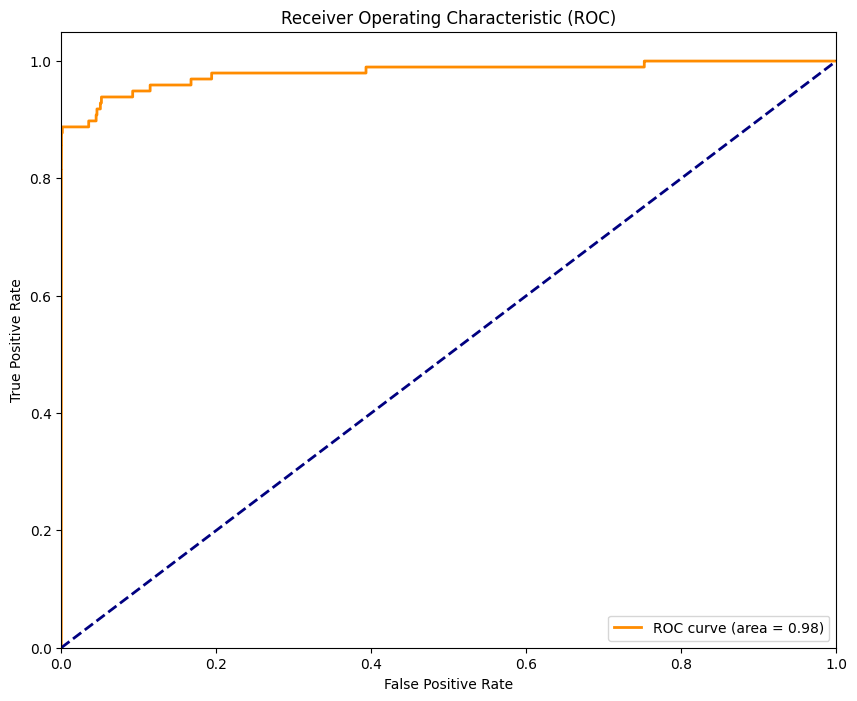

In [ ]:
from sklearn.metrics import roc_curve, auc

y_prob = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()